# Phase II: Data Curation, Exploratory Analysis and Plotting (5\%)

### Team Members:
- Gokul Ramanan
- Fanny Cao
- Gensen Pawlicki
- Haojin He


## Part 1:
(1%) Expresses the central motivation of the project and explains the (at least) two key questions to be explored. Gives a summary of the data processing pipeline so a technical expert can easily follow along.


## Problem Motivation

Understanding the drivers of economic growth has long been a long standing question in economics and data science. In an increasingly interconnected world, the changes in GDP growth among the world’s wealthiest nations show how factors such as education, health, population density, etc shape global wealth and prosperity. This project focuses on identifying the most influential factors behind GDP growth in the top 20 countries by GDP (as of 2024) and determining which of these countries have the potential to grow the most in the next few years based on these various indicators. The key questions are as follows:

1. Which socioeconomic indicators have the strongest influence on GDP growth among the world’s leading economies (as of 2024)?
2. Which countries among the top 20 by GDP have the potential to grow the most over the next few years, based on historical and contemporary socioeconomic indicators?

These questions are motivated by the importance of economic forecasting and policy design through data science. By identifying countries with the highest growth potential, many investors and policymakers can make well informed decisions regarding development priorities for infrastructure, investment strategies for certain products from different countries, and global economic planning.

Motivating sources:
- World Bank. “World Development Indicators.” https://data.worldbank.org/indicator
- wbdata Documentation. https://wbdata.readthedocs.io/en/stable/
- International Monetary Fund. “World Economic Outlook.” https://www.imf.org/en/Publications/WEO

## Summary of the Data Processing Pipeline
To address these questions, this project utilizes the World Bank API via the wbdata Python library, which ensures efficient access to up-to-date economic data. The pipeline we designed ensures data consistency and exploratory data analysis readiness across multiple indicators and time periods.

1. Collect the raw data using the World Bank API
2. Clean and transform the data for visualization and analysis
3. Explore and visualize the data using plotting libraries, such as Seaborn, Plotly, and Matplotlib

To process the data, we first acquired the World Bank API dataset for the top 20 GDP countries. This involved using the wbdata Python library to pull 20 relevant indicators programmatically. After retrieving the raw data, we cleaned it by converting the date column to integer years, filtering to include only the desired timeframe, and addressing missing or inconsistent values across indicators. The cleaned dataset was then reshaped into a flat, country–year structure usable for future analysis.

Next, we engineered new features, including a GDP growth rate column calculated from year-over-year GDP per capita changes. Numeric features were normalized, and the country column was be encoded categorically to allow cross-country comparisons.

Finally, we performed exploratory data analysis to better understand the relationships between indicators and GDP growth. This will include correlation analysis, scatterplots, and time series visualizations to detect patterns, assess multicollinearity, and explore how these factors might inform which countries have the highest growth potential in the coming years.

## Part 2:
(2\%) Obtains, cleans, and merges all data sources involved in the project.

In [76]:
!pip install wbdata

In [77]:
import wbdata as wb
import pandas as pd
import datetime as dt
from sklearn.preprocessing import MinMaxScaler

In [78]:
def clean_data(countries, indicators, year_start, year_end):
  """
    Fetch and preprocess World Bank indicator data for specified countries and years.

    This function retrieves data from the World Bank API for the given indicators and countries,
    converts the date column to integer years, and filters the results to include only data within
    the specified year range.

    Parameters
    ----------
    countries : list of str
        A list of country codes (e.g., ["IN", "US", "CN"]) to retrieve data for.
    indicators : dict
        A dictionary mapping indicator names to World Bank indicator codes.
        Example: {"GDP per capita": "NY.GDP.PCAP.CD"}
    year_start : int
        The starting year of the desired time range.
    year_end : int
        The ending year of the desired time range.

    Returns
    -------
    pandas.DataFrame
        A cleaned DataFrame containing country, date (year), and indicator values
        filtered to the specified range, with a flat index for easier use.
  """

  data = wb.get_dataframe(indicators, country=countries).reset_index()
  data["date"] = data["date"].astype(int)
  data = data[(data["date"] <= year_end) & (data["date"] >= year_start)]
  data = data.dropna(axis=1, thresh= 0.9 * len(data))
  data["country-year"] = data["country"] + " " + data["date"].astype(str)
  data = data.sort_values(by=["country", "date"])

  return data


# List of the top 20 countries ranked by GDP in 2024
# (using ISO-3 country codes as defined by the World Bank API)

countries = ["US", "CN", "DE", "JP", "IN", "GB", "FR", "IT", "CA", "BR", "RU", "MX",
             "AU", "ES", "KR", "ID", "TR", "SA", "NL", "CH"]

# Dictionary of World Bank indicators for GDP growth prediction
# Key = World Bank indicator code
# Value = Custom short name
# Units commented next to each indicator

indicators = {
    # Demographics & Population
    "EN.POP.DNST": "population_density",       # people per sq. km of land area
    "SP.POP.TOTL": "total_population",         # number of people
    "SP.URB.TOTL.IN.ZS": "urban_population_pct", # % of total population living in urban areas
    "SP.DYN.TFRT.IN": "fertility_rate",        # births per woman
    "SP.POP.DPND": "age_dependency_ratio",     # % of working-age population (dependents per 100 working-age people)

    # Health & Capital
    "SP.DYN.LE00.IN": "life_expectancy",       # years
    "SP.DYN.IMRT.IN": "infant_mortality",      # per 1,000 live births
    "SH.XPD.CHEX.PC.CD": "health_exp_pc",      # US$ per capita (current)
    "SH.XPD.CHEX.GD.ZS": "health_exp_gdp_pct", # % of GDP

    # Education System
    "SE.ADT.LITR.ZS": "adult_literacy",        # % of people ages 15+
    "SE.PRM.ENRR": "primary_school_enroll",    # % gross enrollment ratio
    "SE.SEC.ENRR": "secondary_school_enroll",  # % gross enrollment ratio
    "SE.TER.ENRR": "tertiary_school_enroll",   # % gross enrollment ratio
    "SE.XPD.TOTL.GD.ZS": "edu_exp_gdp_pct",    # % of GDP spent on education

    # Economy & Market Growth
    "NY.GDP.PCAP.CD": "gdp_per_capita",        # current US$
    "NE.GDI.TOTL.ZS": "gross_capital_form_pct",# % of GDP (investment)
    "FP.CPI.TOTL.ZG": "inflation_rate",        # annual %, consumer prices
    "SL.UEM.TOTL.ZS": "unemployment_rate",     # % of total labor force
    "NE.TRD.GNFS.ZS": "trade_pct_gdp",         # % of GDP (exports + imports)
    "BX.KLT.DINV.WD.GD.ZS": "fdi_inflows_pct"  # % of GDP (net inflows of FDI)
}

# We want the dataset to include only years between 1980 and 2022
cleaned_data = clean_data(countries, indicators, 1980, 2022)
cleaned_data["gdp_growth"] = cleaned_data.groupby("country")["gdp_per_capita"].pct_change() * 100

# Scale numerical columns that aren't normalized
numeric_cols = ["gdp_per_capita", "total_population"]
scaler = MinMaxScaler()
cleaned_data[numeric_cols] = scaler.fit_transform(cleaned_data[numeric_cols])

# Create numerical country codes for countries
cleaned_data["country_code"] = cleaned_data["country"].astype("category").cat.codes

print(f"The data has {cleaned_data.shape[1]} features and {cleaned_data.shape[0]} observations.")

# Save the cleaned data into a csv for reuseability for ML practice
cleaned_data.to_csv("top20_gdp_indicators_1980_2022.csv", index=False)

The data has 17 features and 860 observations.


/tmp/ipython-input-4151100131.py:81: FutureWarning:

The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



In [79]:
# Test
# Printing first 50 rows of the first cleaned CSV file
gdp_clean_data = pd.read_csv("top20_gdp_indicators_1980_2022.csv")
gdp_clean_data.head()

,country,date,population_density,total_population,urban_population_pct,fertility_rate,age_dependency_ratio,life_expectancy,infant_mortality,gdp_per_capita,gross_capital_form_pct,inflation_rate,trade_pct_gdp,fdi_inflows_pct,country-year,gdp_growth,country_code
0,Australia,1980,1.912448,0.006090,85.552,1.891,53.522721,74.333659,10.8,0.106303,27.086336,10.135841,32.298275,1.244251,Australia 1980,NaN,0
1,Australia,1981,1.942551,0.006253,85.700,1.935,53.127055,74.663415,10.4,0.123764,28.676818,9.487666,31.603439,1.326516,Australia 1981,16.112228,0
2,Australia,1982,1.976524,0.006437,85.670,1.929,52.700172,74.904878,10.1,0.133589,29.833959,11.351820,30.324690,1.178263,Australia 1982,7.807511,0
3,Australia,1983,2.003758,0.006584,85.641,1.924,52.203948,75.146341,9.8,0.120177,25.301720,10.038911,29.175246,1.687262,Australia 1983,-9.886431,0
4,Australia,1984,2.027959,0.006715,85.611,1.840,51.652832,75.387805,9.6,0.129796,26.629791,3.960396,28.540008,0.221289,Australia 1984,7.868673,0


## Part 3:
(2\%) Builds at least two visualizations (graphs/plots) from the data which help to understand or answer the questions of interest. These visualizations will be graded based on how much information they can effectively communicate to readers. Please make sure your visualization are sufficiently distinct from each other.

In [80]:
# importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

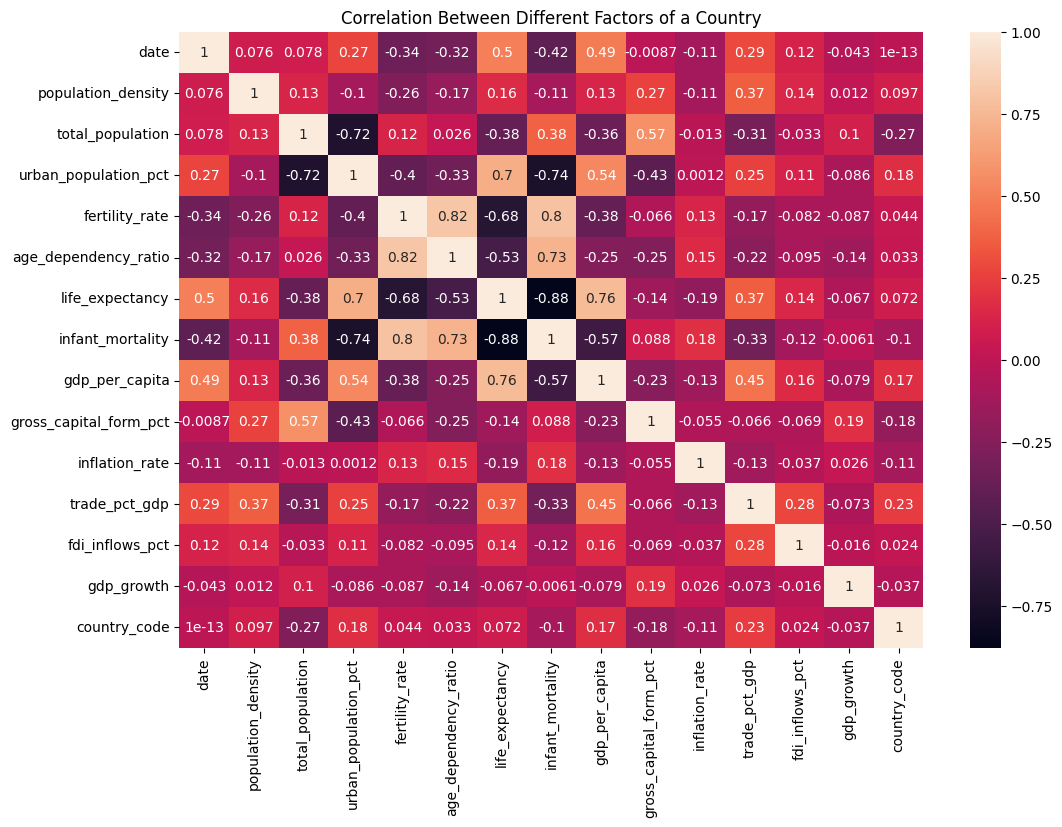

In [81]:
# get the correlations between all the numerical columns
numeric_df = gdp_clean_data.select_dtypes(include=np.number)
correlation = numeric_df.corr()

# create a heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(correlation, annot = True)
plt.title('Correlation Between Different Factors of a Country')
plt.xlabel('')

plt.show()

This heatmap shows the correlation between the different attributes that we have in our data, which can help us determine which data we can use for our analysis and ML models that we will do in the upcoming parts of this project.

The data with the correlations we can use are:

*   gdp_per_capita and total_population (moderately-low negative correlation, -0.36, we should be using these two attributes because we are looking to predict gdp)
*   life_expectancy and gdp_per_capita (strong positive correlation, 0.76, good for looking at potential development)
*   urban_population_pct and gdp_per_capita (moderate positive correlation, 0.54, development)
*   gross_capital_form_pct and gdp_per_capita (weak negative correlation, 0.23, one is for developing countries and one is for developed)

Interstingly, most of the health indicators (infant_mortality, age_dependcy_ratio, life_expectancy, etc) are strongly correlated with the gdp_per_capita attribute. This shows that in our weighted regression model, these factors will take more precedence and importance in our predictions for overall GDP.

In [82]:
# Create a scatterplot using Plotly Express
fig = px.scatter(gdp_clean_data,
                 x="population_density",
                 y="gdp_per_capita",
                 animation_frame="date",
                 animation_group="country",
                 size="total_population",
                 color="country",
                 hover_name="country",
                 size_max=60,
                 range_x=[1, cleaned_data["population_density"].max()],
                 range_y=[0, cleaned_data["gdp_per_capita"].max()])

# Update layout for better readability
fig.update_layout(
    title="Population Density vs. GDP per Capita Over Time (Top 20 Countries)",
    xaxis_title="Population Density (people per sq. km of land area)",
    yaxis_title="GDP per Capita (Scaled)",
    legend_title="Country"
)

# Show the plot
fig.show()

Based off of the animation above, it's quite clear that the countries with a higher overall population have lower GDP per capita values, as wealth must be distributed among more people. The US is a notable outlier here because it has one of the largest overall populations, but due to its low population density, wealth can be distributed more broadly, resulting in the highest GDP per capita by the end of 2022. On the other hand, the Netherlands, with the second largest population density but relatively small overall population, is able to compensate for the density constraints and achieve the third highest GDP per capita by the end of 2022. Throughout the animation, we see India’s total population and population density more than double, yet its GDP per capita growth remains relatively stable compared to other countries. China follows a similar pattern, though with less extreme population density growth and a larger increase in GDP per capita. Overall, the animation highlights the complex dynamics between population size, population density, and GDP per capita, showing that both density and absolute population can significantly influence how wealth is distributed across a country.

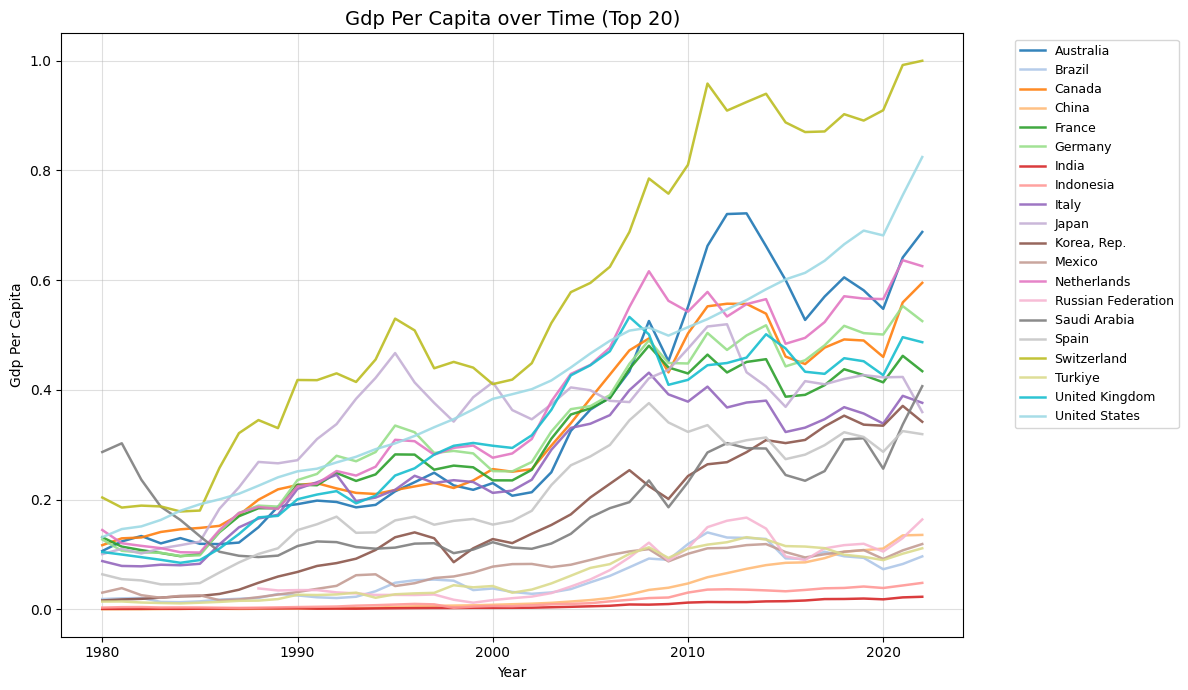

In [83]:
# Choose attribute of interest and create colors for them
attr = "gdp_per_capita"
countries_list = list(gdp_clean_data["country"].unique())
colors = plt.cm.tab20(np.linspace(0, 1, len(countries_list)))

plt.figure(figsize=(12,7))
for (c, d), color in zip(gdp_clean_data.groupby("country"), colors):
    plt.plot(d["date"], d[attr], label=c, color=color, alpha=0.9, linewidth=1.8)

plt.title(f"{attr.replace('_',' ').title()} over Time (Top 20)", fontsize=14)
plt.xlabel("Year")
plt.ylabel(attr.replace('_',' ').title())
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1, fontsize=9)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

The graph illustrates the change in GDP per capita for the world’s top 20 economies from 1980 to 2022, highlighting clear differences in economic growth patterns among developed and emerging nations. Overall, most countries show an upward trend, reflecting steady global economic expansion. Switzerland and the United States maintain the highest GDP per capita levels throughout the period, both exceeding $70,000 by 2022, while countries such as Germany, the United Kingdom, and Japan form a stable mid-range cluster. In contrast, emerging economies like China and India display rapid post-2000 growth, narrowing the gap with advanced nations. Noticeable dips around 2008 and 2020 correspond to the global financial crisis and the COVID-19 pandemic. The chart overall emphasizes long-term growth, resilience, and the gradual shift in global economic balance toward developing regions.